In [1]:
from matplotlib import pyplot as plt
from model.data_prep import get_data
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

torch.set_default_device('mps')
random.seed(2)
np.random.seed(2)
torch.manual_seed(2)

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        output = self.fc(lstm_out)
        return output

# Prepare the data
X, y, scalers = get_data(180)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[2]
hidden_dim = 128
num_layers = 5
output_dim = 9
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


Data prepared successfully


Loss: 0.0179


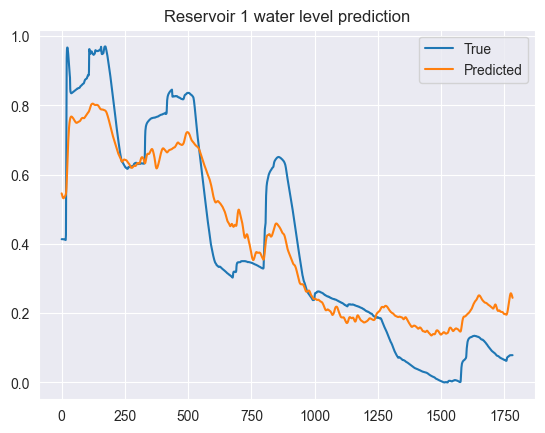

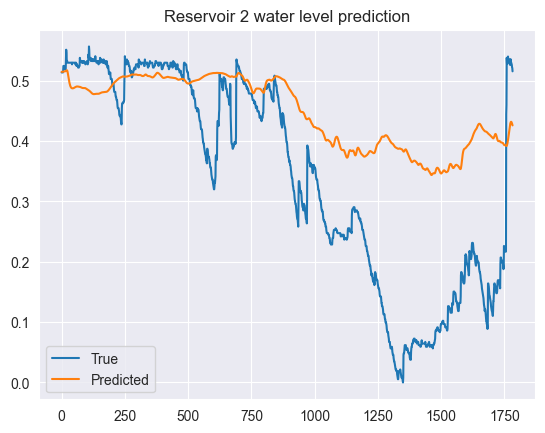

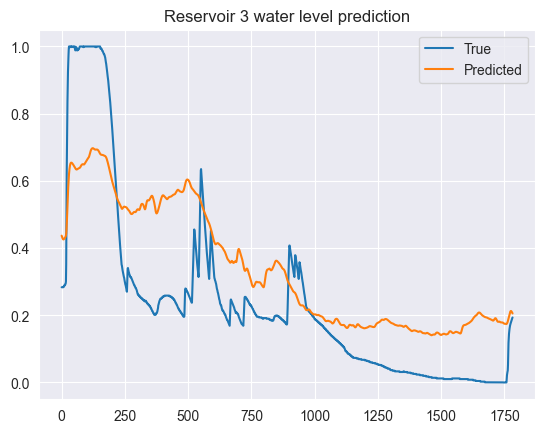

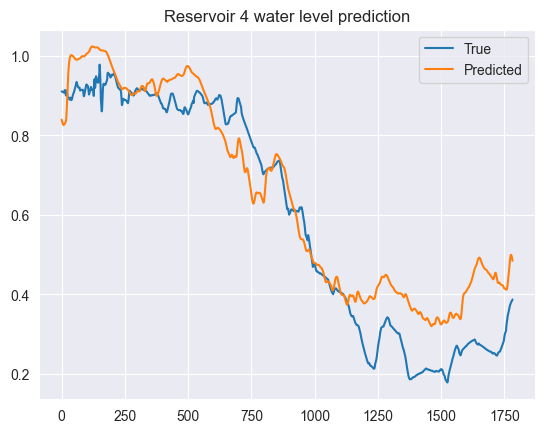

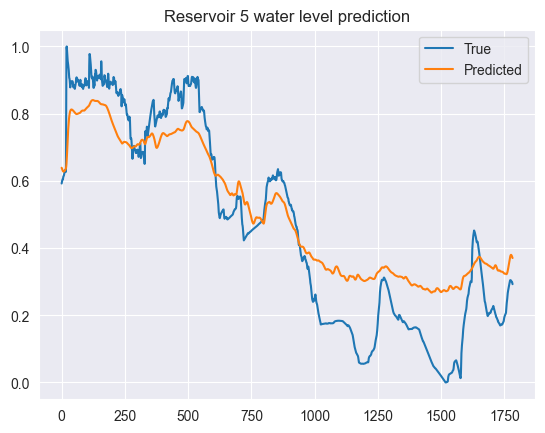

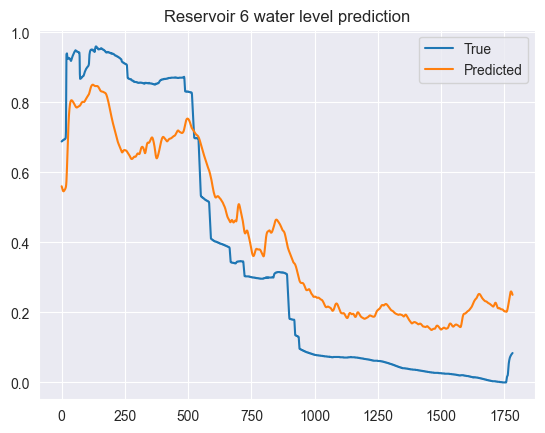

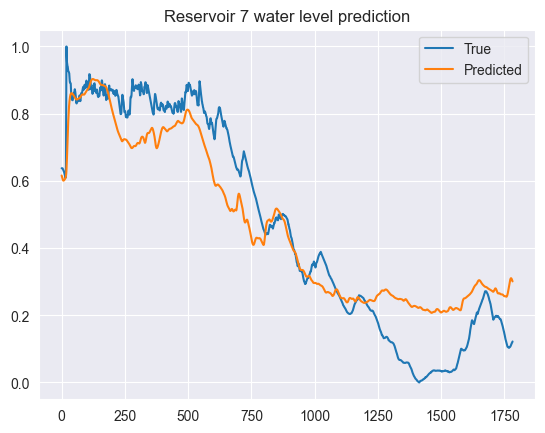

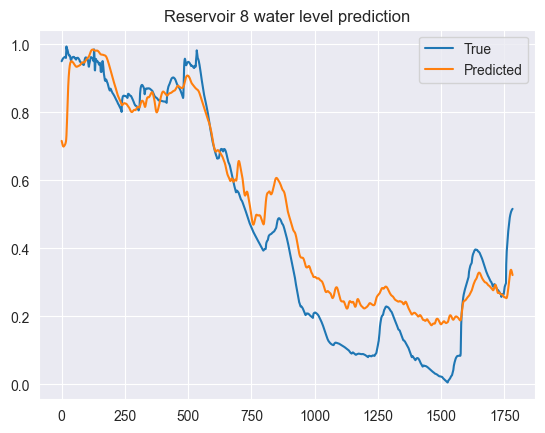

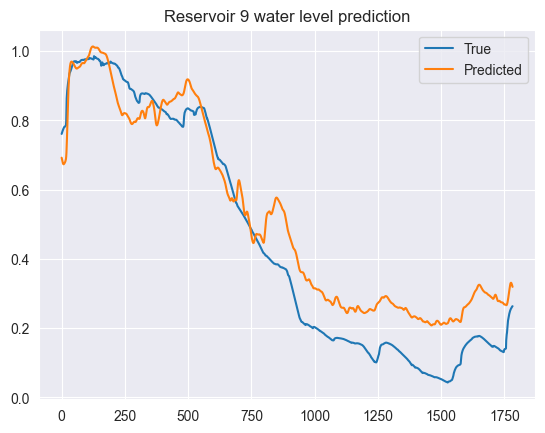

Model saved as 'lstm_model.pth'


In [2]:
# Train the model
num_epochs = 25
batch_size = 24
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
model.eval()
total_predictions = []
with torch.no_grad():
    y_pred = model(X_test)
    loss = criterion(y_pred, y_test)
    print(f'Loss: {loss.item():.4f}')
    total_predictions.append(y_pred)
# Print one chart for each reservoir
for i in range(9):
    plt.plot(y_test[:, i].cpu().numpy(), label='True')
    plt.plot(total_predictions[0][:, i].cpu().numpy(), label='Predicted')
    plt.title(f'Reservoir {i+1} water level prediction')
    plt.legend()
    plt.show()


# Save the model
torch.save(model.state_dict(), 'model/final_models/model_test/lstm_model.pth')
print("Model saved as 'lstm_model.pth'")

Model loaded successfully
Loss: 0.0179


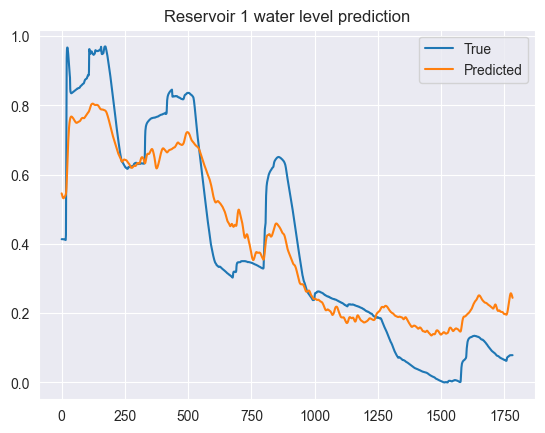

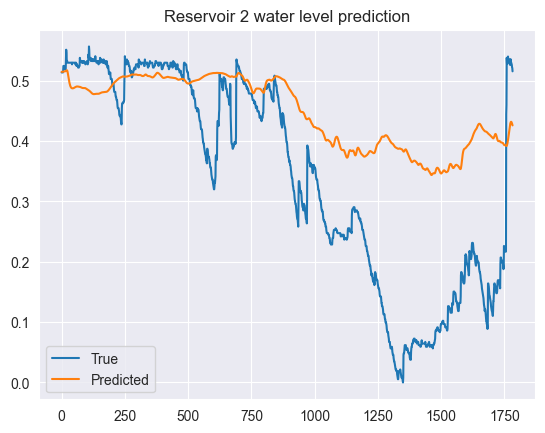

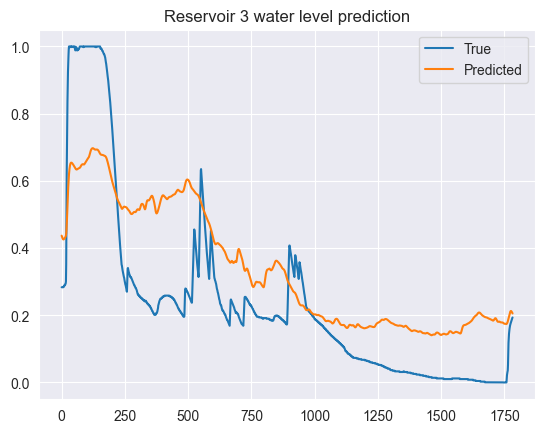

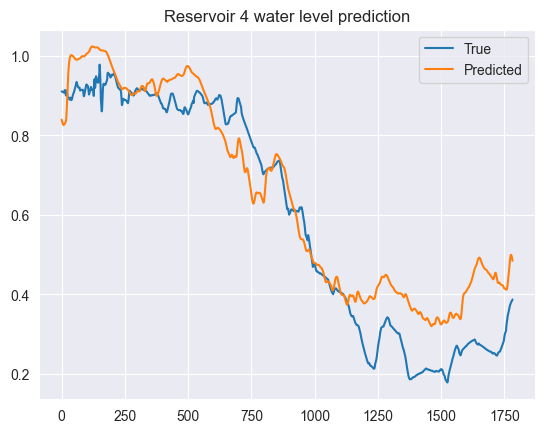

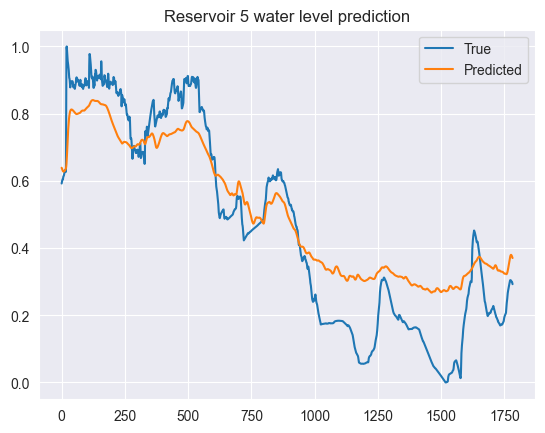

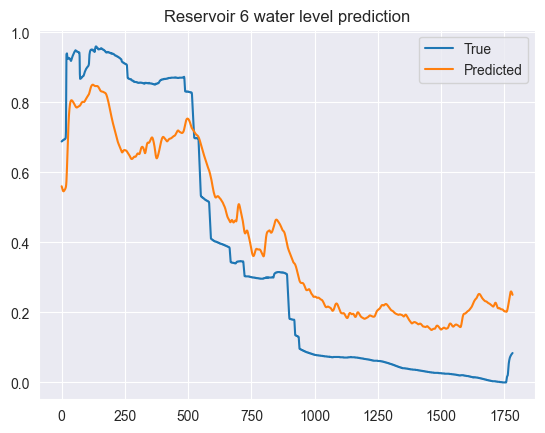

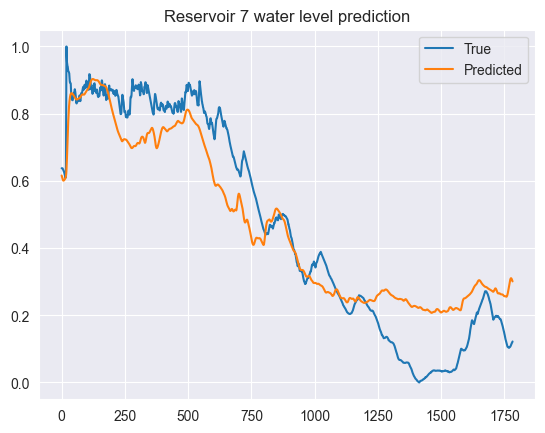

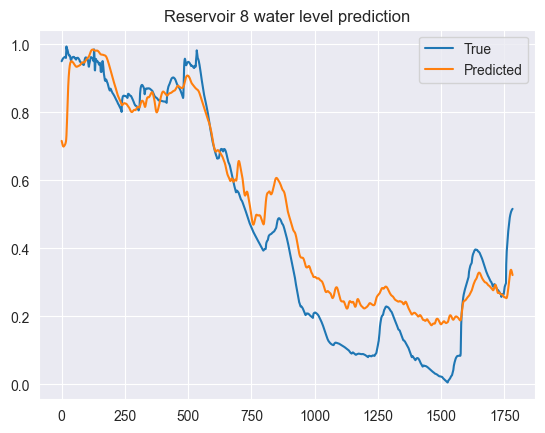

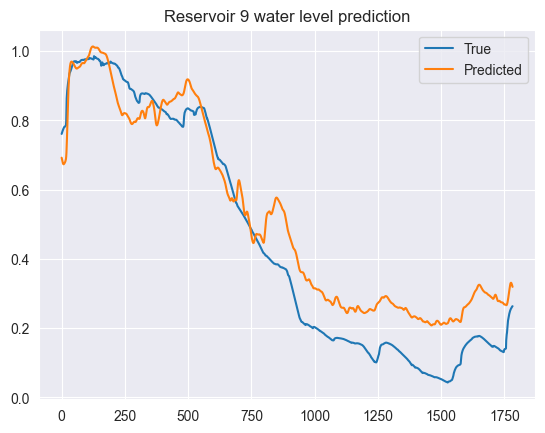

In [2]:
# Load the model
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model.load_state_dict(torch.load('model/final_models/model_test/lstm_model.pth', weights_only=True))
model.eval()
print("Model loaded successfully")

total_predictions = []
with torch.no_grad():
    y_pred = model(X_test)
    loss = criterion(y_pred, y_test)
    print(f'Loss: {loss.item():.4f}')
    total_predictions.append(y_pred)
# Print one chart for each reservoir
for i in range(9):
    plt.plot(y_test[:, i].cpu().numpy(), label='True')
    plt.plot(total_predictions[0][:, i].cpu().numpy(), label='Predicted')
    plt.title(f'Reservoir {i+1} water level prediction')
    plt.legend()
    plt.show()